# Figure 9: colour plots for the invasion probability and expected time over all possible initial state conditions for the 30 mosquito model with no reversion

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Import required libraries

In [1]:
import numpy as np
import pylab as plt
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

Import required scripts

In [2]:
import importlib
import Rate_transitions
import Finding_dictionary_keys
import Prob_absorb_to_each
import Time_absorb_wild_states
import Hughes_model

get_transition = Rate_transitions.get_transition_Hughes
find_keys = Finding_dictionary_keys.find_keys
prob_reach_absorb = Prob_absorb_to_each.prob_reach_absorb_Hughes
F = Hughes_model.F_hughes
absorb_time_wolb = Time_absorb_wild_states.absorb_time_wolb_Hughes
absorb_time_ext = Time_absorb_wild_states.absorb_time_ext

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

Parameter values

In [3]:
K = 30        # reproductive carrying capacity
d1 = 12/100   # wild-type death rate
d2 = 12/100   # Wolbachia death rate
phi = 85/100    # Wolbachia fitness

v = 10/10     # probability of vertical transmission
u = 10/10     # ratio of unviable offspring produced by an infected male and uninfected female

k = 0.3           # Mosquito competition parameter
h = 0.19*100**k   # Mosquito competition parameter

b1 = round(d1/F(10,h,k,K),2) # wild-type per capita birth rate
b2 = b1*phi                # Wolbachia per capita birth rate

# create a dictionary to store all parameter values
params_dict = {'b1': b1,
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': v,
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }

Construct dictionaries for the full state space and the transient state space (mixed states)

In [4]:
max_pop = 30  # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}
trans_dict = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(1,max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}

Calculating the probability of reaching the wolbachia-only state space from each initial condition state

In [5]:
n_transient = len(trans_dict)            # number of transient states i.e. mixed
prob_reach_wolb = np.zeros(n_transient)  # initialise an array to hold all the probabilities for the mixed states
for i in range(max_pop):                 # looping over the Wolbachia-only state space
    absorb_state = np.array([0,i+1])     # current Wolbachia-only state (absorbing state)
    # adding the probability of reaching that state from each initial mixed state to the probabilities array
    prob_reach_wolb[:] += np.transpose(prob_reach_absorb(state_dict,trans_dict,absorb_state,params_dict)[0])[0]

Putting the probabilities into an array in the correct format for the colour plot and adding the trivial probabilities of invasion from the wild-type-only and Wolbachia-only states

In [6]:
col_map = np.zeros((max_pop+1,max_pop+1))  # initialing array for all the probabilities

for i in range(max_pop):   # looping over the wild-type/ Wolbachia-only state space
    col_map[i+1,0] = 0     # probability of invasion starting from a wild-type only state is 0
    col_map[0,i+1] = 1     # probability of invasion starting from a Wolbachia only state is 1
    
for k in range(n_transient):         # looping over all the mixed/ transient states
    # setting the index of the current invasion probability corresponding to the intial state
    indx1, indx2 = trans_dict[k]
    col_map[indx1,indx2] = prob_reach_wolb[k]  # recording the probability

Finding the smalest numbers of Wolbachia-infected mosquitoes across the colour map that achieve 0.9 or higher invasion probability

In [7]:
high_m = np.where(col_map >= 0.9)[0]  # indices of wild-type only states with invasion probability >= 0.9
high_w = np.where(col_map >= 0.9)[1]  # indices of Wolbachia only states with invasion probability >= 0.9
min_m = []  
min_w = []

# take the smallest Wolbachia-only state
for i in range(max_pop+1):
    if i in high_m:
        indxs = np.where(high_m == i)
        min_m.append(i)
        min_w.append(np.min(high_w[indxs]))

In [8]:
# proportion of Wolbachia-infected required for invasion to be successful with probability >= 0.9
min_m = np.array(min_m)  # make into numpy array
min_w = np.array(min_w)

result = min_w / (min_m + min_w)
print('proportions of Wolbachia-infected required', result)

proportions of Wolbachia-infected required [1.         0.8        0.75       0.72727273 0.69230769 0.6875
 0.66666667 0.66666667 0.65217391 0.65384615 0.64285714]


(a) Plotting the figure

Text(0.5, 1.0, 'Invasion probability')

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


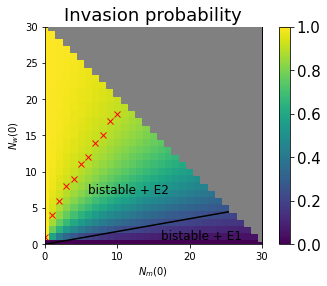

In [9]:
fig, ax = plt.subplots()  # define subsplots, as overlaying mean-field results
matplotlib.rcParams.update({'font.size': 15})  # font size

Z = np.transpose(col_map)   # swaps to correct way round 
my_cmap = plt.cm.viridis    # colour scheme
num_levels = 1000000      # number of levels in colour map

my_cmap = ListedColormap(my_cmap(np.linspace(0, 1, num_levels)))   # define how fine a colour scale want
color_plot = ax.imshow(Z, cmap = my_cmap, interpolation ='nearest', origin = 'lower')  # produces colour plot

ax.set_xlabel('$N_m(0)$')   # x label
ax.set_ylabel('$N_w(0)$')   # y label

x = np.arange(Z.shape[1])   # extracts the x values
det_bound = np.load('det_boundary.npy')   # import deterministic boundary
ax.plot(x,det_bound, color='black')  # plot deterministic boundary

# greys out the states which lie outside of the state space
current_axes = plt.gca()          # saves current axes
for i in range(max_pop):   # looping over the y axis
    highlight_row, highlight_col = max_pop-i,1+i
    rect = Rectangle((highlight_col - 0.5, highlight_row - 0.5), max_pop, 1, edgecolor='gray', facecolor='gray', zorder=3)
    current_axes.add_patch(rect)    # adds the rectangle

ax.set_xlim(0,30)   # x limit
ax.set_ylim(0,30)   # y limit

# labels SS attraction under mean-field model
plt.text(6,7,'bistable + E2',fontsize=12)
plt.text(16,0.7,'bistable + E1',fontsize=12)

plt.plot(min_m, min_w, 'rx')    # plots the minimum invasion probability states

color_bar = fig.colorbar(color_plot)   # adds colour bar
ax.set_title('Invasion probability')    # title

#plt.savefig('bifurcation_color_map_phi085_v1_qu.pdf', bbox_inches='tight')  # saves figure

Finding the probability of invasion along the deterministic boundary

In [10]:
Nw_vec = np.round(det_bound) # round the deterministic boundary to the nearest integer
prob_bound = np.zeros(max_pop+1)   # initialise array to hold the probabilities
for i in range(max_pop+1):                      # looping over each wild-type only value
    prob_bound[i] = col_map[i,int(Nw_vec[i])]     # find the corresponding probability
    print(i,Nw_vec[i],col_map[i,int(Nw_vec[i])])  # print wiltype value, Wolbachia value and probability

filt = np.nonzero(prob_bound)   # filter out the zero probabilities
print(prob_bound,np.mean(prob_bound[filt]))   # take the mean of the non-zero probabilities

0 -0.0 0.0
1 0.0 0.0
2 0.0 0.0
3 1.0 0.3327808814756701
4 1.0 0.2752563256175122
5 1.0 0.23435732523239752
6 1.0 0.2036937202015011
7 1.0 0.1798361917875217
8 1.0 0.16075341422353176
9 2.0 0.2744425333339187
10 2.0 0.25231043954996224
11 2.0 0.23322839863095185
12 2.0 0.21662987546876095
13 2.0 0.202077918502361
14 2.0 0.18923034960513094
15 3.0 0.2597458787885877
16 3.0 0.24573677519234213
17 3.0 0.23304116019664287
18 3.0 0.2214924940954556
19 3.0 0.21095010948125903
20 4.0 0.26371484075509594
21 4.0 0.2526138231045405
22 4.0 0.24232704135601327
23 4.0 0.23277057085799413
24 4.0 0.22386953583079833
25 4.0 0.21555717306349817
26 5.0 0.0
27 5.0 0.0
28 5.0 0.0
29 5.0 0.0
30 5.0 0.0
[0.         0.         0.         0.33278088 0.27525633 0.23435733
 0.20369372 0.17983619 0.16075341 0.27444253 0.25231044 0.2332284
 0.21662988 0.20207792 0.18923035 0.25974588 0.24573678 0.23304116
 0.22149249 0.21095011 0.26371484 0.25261382 0.24232704 0.23277057
 0.22386954 0.21555717 0.         0.       

To reproduce Figure 10 see comments at the end of the 'Figure_3.ipynb'.

Finding the expected time until the Wolbachia-only state space is reached with respect to each possible mixed state.

In [11]:
invade_time = absorb_time_wolb(max_pop,np.ones(n_transient),params_dict) # finding the expected invasion times

In [12]:
# expected time until invasion from the state (5,5)
key = next((k for k, v in trans_dict.items() if np.array_equal(v, np.array([5,5]))), None)
invade_time[key]

22.970103229256424

Putting the expected times into an array in the correct format for the colour plot and adding the trivial invasion times from the wild-type-only and Wolbachia-only states.

In [13]:
col_map_time = np.zeros((max_pop+1,max_pop+1))  # initialing array for all the invasion times
    
for k in range(n_transient):    # looping over all the mixed/ transient states                  
    # setting the index of the current invasion probability corresponding to the intial state
    indx1, indx2 = trans_dict[k]
    col_map_time[indx1,indx2] = invade_time[k]  # recording the expcted invasion time
    
for i in range(max_pop):  # looping over the wild-type/ Wolbachia-only state space
    # invasion time starting from a wild-type only state is infinite 
    # (we just use a place holder here and colout accordingly in the figure)
    col_map_time[i+1,0] = 0     
    col_map_time[0,i+1] = 0  # expected invasion time from a Wolbachia-only state is 0

(b) Plotting the figure

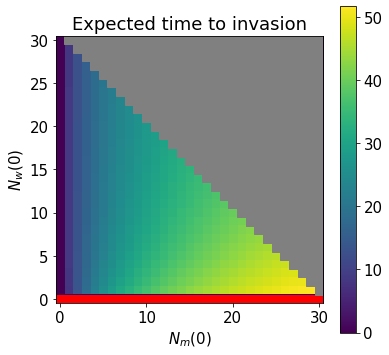

In [14]:
matplotlib.rcParams.update({'font.size': 15})   # font size 
plt.figure(figsize=(6, 6))                      # figure size

Z = np.transpose(col_map_time)    # change to right way round
my_cmap = plt.cm.viridis          # colour scheme
num_levels = 100000

my_cmap = ListedColormap(my_cmap(np.linspace(0, 1, num_levels)))   # define how fine a colour scale want
plt.imshow(Z, cmap=my_cmap, interpolation='nearest', origin='lower')  # produces colour plot

plt.xlabel('$N_m(0)$')  # x label
plt.ylabel('$N_w(0)$')  # y label

# highlights the specific squares with a red rectangle
# this is to denote the initial states over which the expected time to invasion is infinite
highlight_row, highlight_col = 0, 0
rect = Rectangle((highlight_col - 0.5, highlight_row - 0.5), 31, 1, facecolor='red')
current_axes = plt.gca()          # saves current axes
current_axes.add_patch(rect)      # adds rectangle

# colours the squares corresponding to the state space that is out of bounds grey
for i in range(max_pop):   # looping over the y axis
    highlight_row, highlight_col = max_pop-i,1+i
    rect = Rectangle((highlight_col - 0.5, highlight_row - 0.5), max_pop, 1, edgecolor='gray', facecolor='gray')
    current_axes.add_patch(rect)    # adds the rectangle

plt.colorbar()    # adds colour bar
plt.title('Expected time to invasion')        # title
plt.savefig('absorb_time_color_map_phi085_v1_qu.pdf', bbox_inches='tight')   # save figure

For Figures A6 in the Appendix, change the larval density function and then rerun the notebook.

For Figures C17 in the Appendix, change $v=0.9$ and rerun the notebook.